In [6]:
import os, sys
import numpy as np
import re
import pandas as pd

import matplotlib
%matplotlib inline
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

plt.style.use('ggplot')

caffe_root = '/home/ashu/Desktop/Thesis Work/Classifier/caffe/'
print os.getcwd()
sys.path.insert(0, caffe_root + 'python')
import caffe

import argparse

from caffe.proto import caffe_pb2
import google.protobuf as pb2
import google.protobuf.text_format

import lmdb
from collections import defaultdict
from sklearn.metrics import confusion_matrix

/home/ashu/Desktop/Thesis Work/Classifier/caffe/models/script


In [7]:
def compute_average_prec(rec, prec):
    
    # Correct Method
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
         mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

- Load class labels val.txt

In [8]:
cls_lbl_file = caffe_root + 'data/5_class_dataset/labels/val.txt'
# read the labels file
with open(cls_lbl_file, 'r') as f:
    cls_data=f.readlines()
    
cls_data = [x.strip() for x in cls_data]

# append image name and its label in a dictionary
cls_lbl = {}
for val in cls_data:
    img, lbl = val.split(' ')
    cls_lbl[img] = lbl
    
print len(cls_data), len(cls_lbl)

9846 9846


In [9]:
# load all states indexed acc to img id in a dictionary
state_lbl = {}
st_lbl_laptop = caffe_root + 'data/5_class_dataset/labels/val_laptop_state.txt'
st_lbl_scissor = caffe_root + 'data/5_class_dataset/labels/val_scissor_state.txt'
st_lbl_suitcase = caffe_root + 'data/5_class_dataset/labels/val_suitcase_state.txt'
st_lbl_toilet = caffe_root + 'data/5_class_dataset/labels/val_toilet_state.txt'
st_lbl_umbrella = caffe_root + 'data/5_class_dataset/labels/val_umbrella_state.txt'

with open(st_lbl_laptop, 'r') as f:
    st_data_laptop=f.readlines()    
st_data_laptop = [x.strip() for x in st_data_laptop]

with open(st_lbl_scissor, 'r') as f:
    st_data_scissor=f.readlines()    
st_data_scissor = [x.strip() for x in st_data_scissor]

with open(st_lbl_suitcase, 'r') as f:
    st_data_suitcase=f.readlines()    
st_data_suitcase = [x.strip() for x in st_data_suitcase]

with open(st_lbl_toilet, 'r') as f:
    st_data_toilet=f.readlines()    
st_data_toilet = [x.strip() for x in st_data_toilet]

with open(st_lbl_umbrella, 'r') as f:
    st_data_umbrella=f.readlines()    
st_data_umbrella = [x.strip() for x in st_data_umbrella]

# concatenating all list
st_data = st_data_laptop + st_data_scissor + st_data_suitcase + st_data_toilet + st_data_umbrella

# appending the state information in one dictionary
for val in st_data:
    img, lbl = val.split(' ')
    state_lbl[img] = lbl
    
    
print len(cls_data), len(state_lbl), len(st_data)

9846 9846 9846


- create prototxt and caffe model filename
- create the transformer as well

- create 2 list to carry tp and fp for each class
- 2D list indexed acc to class label
- loop through each file in val txt, load class label and feed fwd image
- take predictions and acc to class label update app tp and fp
- end all list ll be of unequal size
- cal prec and recall at each point and finally compute avg precision

In [10]:
caffe.set_mode_gpu()

# laptop:0, scissor:1, suitcase:2, toilet:3, umbrella:4
img_dir = caffe_root + 'data/5_class_dataset/images/val/'

# Modify the paths given below
deploy_prototxt_file_path = caffe_root + 'models/gt_classifier/all/test.prototxt' # Network definition file

iteration = range(1000, 51000, 1000)
df = pd.DataFrame(columns=['#Iteration','Laptop','Scissor','Suitcase','Toilet','Umbrella','mAP'])

for it in iteration:
    caffe_model_file_path = caffe_root + 'models/gt_classifier/all/trained_model/' + \
                            str(max(iteration)) + '/gt_all_' +  str(max(iteration)) + \
                            '_iter_' + str(it) + '.caffemodel'
    
    net = caffe.Net(deploy_prototxt_file_path, caffe_model_file_path, caffe.TEST)
    
    # set the transformeer
    # load the mean ImageNet image (as distributed with Caffe) for subtraction
    mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
    mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
    print 'mean-subtracted values:', zip('BGR', mu)

    # create transformer for the input called 'data'
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

    transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
    transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
    transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
    transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

    net.blobs['data'].reshape(1,        # batch size
                              3,         # 3-channel (BGR) images
                              224, 224)  # image size is 227x227
    
    
    #extract fc7 multipliers and take mod of vector, must of length 4096
    wt = net.params['cls_score'][0].data[...].clip(min=0)   
    #wt = wt.clip(min=0)
    #print wt
    
    tp = [[] for _ in range(5)]
    fp = [[] for _ in range(5)]
    p_score = [[] for _ in range(5)]
    
    for k,v in cls_lbl.iteritems():
        
        # load image, transform and feed forward
        image = caffe.io.load_image(img_dir + k)
        transformed_image = transformer.preprocess('data', image)
        net.blobs['data'].data[...] = transformed_image
        output = net.forward()
        plabel = int(output['prob'][0].argmax(axis=0))
        score = float(output['prob'][0].max(axis=0))
        label = int(v)
        
        # Assign tp and fp to appropiate list
        if plabel == 0 : # laptop Image
            p_score[plabel].append(score)
            if label == 0:
                tp[plabel].append(1)
                fp[plabel].append(0)
            else:
                fp[plabel].append(1)
                tp[plabel].append(0)
                
        elif plabel == 1: # Scissor Image
            p_score[plabel].append(score)
            if label == 1:
                tp[plabel].append(1)
                fp[plabel].append(0)
            else:
                fp[plabel].append(1)
                tp[plabel].append(0)
                
        elif plabel == 2: # Scissor Image
            p_score[plabel].append(score)
            if label == 2:
                tp[plabel].append(1)
                fp[plabel].append(0)
            else:
                fp[plabel].append(1)
                tp[plabel].append(0)
                
        elif plabel == 3: # Scissor Image
            p_score[plabel].append(score)
            if label == 3:
                tp[plabel].append(1)
                fp[plabel].append(0)
            else:
                fp[plabel].append(1)
                tp[plabel].append(0)
                
        elif plabel == 4: # Scissor Image
            p_score[plabel].append(score)
            if label == 4:
                tp[plabel].append(1)
                fp[plabel].append(0)
            else:
                fp[plabel].append(1)
                tp[plabel].append(0)
                
    # count tp fp for each and avg prec
    ap = []
    for i in range(5):
        print i, len(tp[i]), len(fp[i])
        npos = len(tp[i])
        new_tp = np.array(tp[i])
        new_fp = np.array(fp[i])        
        new_score = np.array(p_score[i])
        
        #get sorted indices of open and close acc to score
        sorted_ind = np.argsort(-new_score)
        
        new_tp = new_tp[sorted_ind]
        new_fp = new_fp[sorted_ind]
        
        new_fp = np.cumsum(new_fp)
        new_tp = np.cumsum(new_tp)
        
        rec = new_tp / float(npos)
        # avoid divide by zero in case the first detection matches a difficult
        prec = new_tp / np.maximum(new_tp + new_fp, np.finfo(np.float64).eps)
        
        ap.append(compute_average_prec(rec, prec)) 
        print 'Average Precision for ' + str(i) + ' : ', ap[i]
    
    print 'Mean AP: ', np.mean(ap)        
    data = {'#Iteration' : it, 'Laptop' : ap[0], 'Scissor' : ap[1], 'Suitcase' : ap[2], 'Toilet' : ap[3], \
            'Umbrella' : ap[4], 'mAP' : np.mean(ap)}
    
    df = df.append(data, ignore_index=True)

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 1819 1819
Average Precision for 0 :  0.797409451267
1 361 361
Average Precision for 1 :  0.718207631
2 3052 3052
Average Precision for 2 :  0.601510875762
3 1268 1268
Average Precision for 3 :  0.972033680086
4 3346 3346
Average Precision for 4 :  0.944391022075
Mean AP:  0.806710532038
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 1950 1950
Average Precision for 0 :  0.787238835813
1 303 303
Average Precision for 1 :  0.833187516106
2 1968 1968
Average Precision for 2 :  0.793727870683
3 1280 1280
Average Precision for 3 :  0.977372655034
4 4345 4345
Average Precision for 4 :  0.831335026382
Mean AP:  0.844572380804
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 1835 1835
Average Precision for 0 :  0.827352205677
1 334 334
Average Precision for 1 :  0.807352789856

Mean AP:  0.86274650398
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 1955 1955
Average Precision for 0 :  0.830253988576
1 355 355
Average Precision for 1 :  0.835527134459
2 2471 2471
Average Precision for 2 :  0.762972559046
3 1406 1406
Average Precision for 3 :  0.95694927727
4 3659 3659
Average Precision for 4 :  0.94414491028
Mean AP:  0.865969573926
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 1998 1998
Average Precision for 0 :  0.816105935456
1 347 347
Average Precision for 1 :  0.842547845926
2 2385 2385
Average Precision for 2 :  0.778501428235
3 1396 1396
Average Precision for 3 :  0.962428328879
4 3720 3720
Average Precision for 4 :  0.936834980065
Mean AP:  0.867283703712
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 1975 1975
Average Precision for 0 :  0.825895594331
1 346 346
Average Precisio

Mean AP:  0.871351533529
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 1938 1938
Average Precision for 0 :  0.838240115068
1 359 359
Average Precision for 1 :  0.840643679289
2 2447 2447
Average Precision for 2 :  0.772677225969
3 1369 1369
Average Precision for 3 :  0.967038916146
4 3733 3733
Average Precision for 4 :  0.93728015324
Mean AP:  0.871176017943
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 1950 1950
Average Precision for 0 :  0.834642644047
1 359 359
Average Precision for 1 :  0.840650233606
2 2427 2427
Average Precision for 2 :  0.775241899428
3 1370 1370
Average Precision for 3 :  0.967071032
4 3740 3740
Average Precision for 4 :  0.936325264195
Mean AP:  0.870786214655
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 1946 1946
Average Precision for 0 :  0.836272210385
1 362 362
Average Precision

In [11]:
print df

    #Iteration    Laptop   Scissor  Suitcase    Toilet  Umbrella       mAP
0       1000.0  0.797409  0.718208  0.601511  0.972034  0.944391  0.806711
1       2000.0  0.787239  0.833188  0.793728  0.977373  0.831335  0.844572
2       3000.0  0.827352  0.807353  0.681763  0.982008  0.916607  0.843017
3       4000.0  0.698150  0.789809  0.790494  0.934173  0.923961  0.827317
4       5000.0  0.805152  0.857692  0.766881  0.940772  0.906176  0.855335
5       6000.0  0.647692  0.792391  0.757922  0.953706  0.968301  0.824002
6       7000.0  0.852573  0.753459  0.691489  0.968942  0.946359  0.842564
7       8000.0  0.820315  0.810076  0.702005  0.980505  0.937052  0.849991
8       9000.0  0.865839  0.805160  0.740658  0.951617  0.914328  0.855520
9      10000.0  0.850147  0.855490  0.708664  0.969325  0.936361  0.863997
10     11000.0  0.892040  0.814072  0.741943  0.973127  0.909392  0.866115
11     12000.0  0.887289  0.842603  0.736023  0.969050  0.914101  0.869813
12     13000.0  0.824556 

In [12]:
csv_file = caffe_root + 'models/gt_classifier/all/Results/gt_classifier_all_' \
            + str(max(iteration)) + '.csv'
df.to_csv(csv_file)

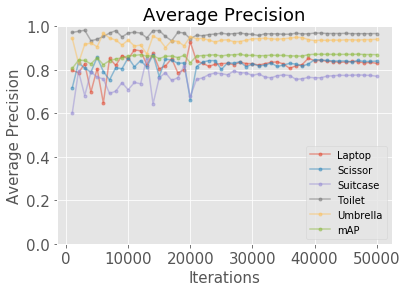

In [13]:
'''
Plot AP
'''
plot_path = csv_file[:-4] + '_result.png'
#path = caffe_root + 'models/gt_classifier/laptop/Results/Results_50000.csv'
df_plot = pd.read_csv(csv_file)
fig, ax1 = plt.subplots()

#Plotting training and test losses
Laptop, = ax1.plot(df_plot['#Iteration'], df_plot['Laptop'],  alpha=.5, marker='.')
Scissor, = ax1.plot(df_plot['#Iteration'], df_plot['Scissor'], alpha=.5,  marker='.')
Suitcase, = ax1.plot(df_plot['#Iteration'], df_plot['Suitcase'], alpha=.5,  marker='.')
Toilet, = ax1.plot(df_plot['#Iteration'], df_plot['Toilet'], alpha=.5,  marker='.')
Umbrella, = ax1.plot(df_plot['#Iteration'], df_plot['Umbrella'], alpha=.5,  marker='.')
mAP, = ax1.plot(df_plot['#Iteration'], df_plot['mAP'], alpha=.5,  marker='.')
ax1.set_ylim(ymin=0, ymax=1)
ax1.set_xlabel('Iterations', fontsize=15)
ax1.set_ylabel('Average Precision', fontsize=15)
ax1.tick_params(labelsize=15)

plt.legend([Laptop, Scissor,Suitcase,Toilet,Umbrella,mAP], \
           ['Laptop', 'Scissor', 'Suitcase', 'Toilet', 'Umbrella', 'mAP'], \
           loc='lower right')
plt.title('Average Precision', fontsize=18)
#plt.show()
plt.savefig(plot_path)